# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD)

for
- linear regression
- logistic regression

models.

The proximal operators we will use are the
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "Anasse"
ln1 = "ESSALIH"
fn2 = "Constantin"
ln2 = "GUILLAUME"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_essalih_anasse_and_guillaume_constantin.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

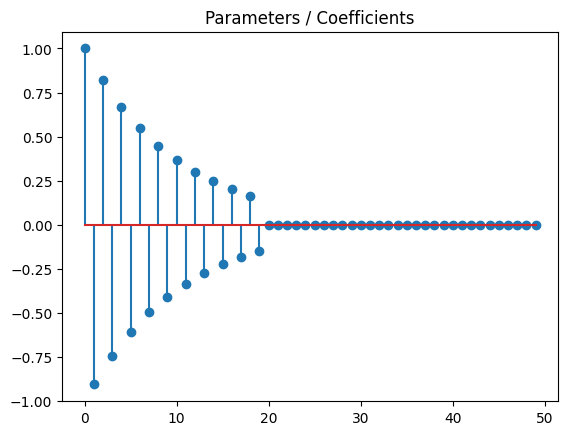

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """

    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

<ipython-input-5-0cc27298cefe>:2: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Generate the data

In [ ]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1
    </li>
    </ul>
</div>

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""

    return np.sign(x)*np.maximum(np.abs(x)-lmbd,0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.sum(np.abs(x)) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    return (1/(1+lmbd))*x # TODO

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return (lmbd/2)*np.linalg.norm(x, 2)**2 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

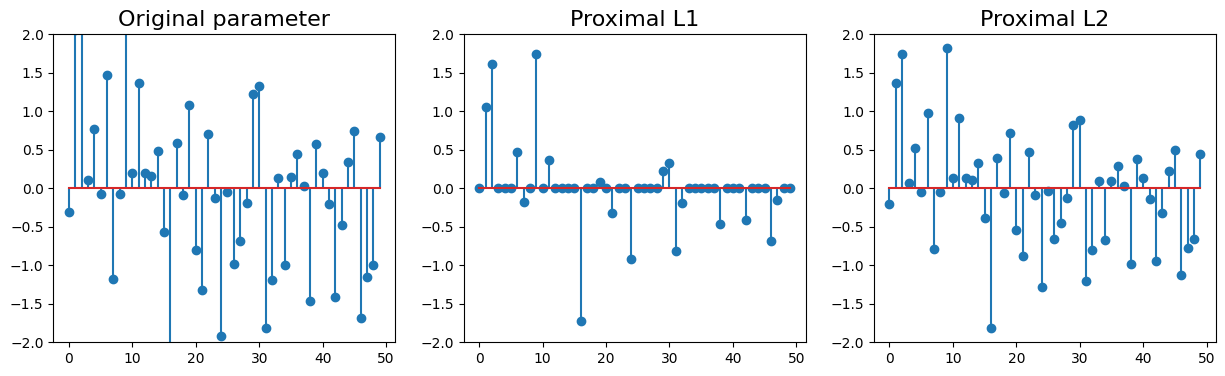

In [ ]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
<b>The proximal operator for L1 penalization</b> results in sparsity in the coefficients (i.e., some values are pushed to zero).<br><br>
<b>The proximal operator for L2 penalization</b> shrinks the coefficients but doesn't make any coefficients exactly zero.<br><br>
We can conclude that <b>L1 regularization</b> tends to create sparse solutions by driving coefficients to zero, while <b>L2 regularization</b> uniformly reduces the magnitude of the coefficients.
</div>


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [ ]:
def loss_linreg(x):
    """Least-squares loss"""
    global A
    global b
    k = A.shape[0]
    return (1/(2*k))*np.sum((b-A.dot(x))**2)

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    global A
    global b
    k = A.shape[0]
    return (1/k)*(A.T.dot(A.dot(x)-b))

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    global A
    global b
    return np.mean(np.log(1+np.exp(-b*A.dot(x))))

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    global A
    global b
    k = A.shape[0]
    return (1/k)*np.dot(A.T, (-b*np.exp(-b*A.dot(x))/(1+np.exp(-b*A.dot(x)))))

# Sanity Check

# Test gradient implementation
from scipy.optimize import check_grad

# Generate data for testing
n_features = 50
n_samples = 1000
A_lin, b_lin = simu_linreg(coefs)
A_log, b_log = simu_logreg(coefs)

# Function to check gradient for linear regression
def f_lin(x):
    return loss_linreg(x)

def g_lin(x):
    return grad_linreg(x)

# Function to check gradient for logistic regression
def f_log(x):
    return loss_logreg(x)

def g_log(x):
    return grad_logreg(x)

# Test point
x_test = np.random.randn(n_features)

# Check gradients
A,b=A_lin,b_lin
print("Linear regression gradient check:", check_grad(f_lin, g_lin, x_test))
A,b=A_log,b_log
print("Logistic regression gradient check:", check_grad(f_log, g_log, x_test))

Linear regression gradient check: 1.9058976034923857e-06
Logistic regression gradient check: 1.2458599802849844e-07


<div style="background-color: #d4edda; padding: 10px; border-radius: 5px;">
The difference between the computed gradient and the numerical gradient is extremely small, which confirms that the gradient for linear and logistic regression has been implemented correctly.
</div>


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$.

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and
  logistic regression losses. Note that the operator norm of a matrix can
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [ ]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    # TODO
    n=A.shape[0]
    return np.linalg.norm(A.T@A,2)/n
# Calculate the smoothness constant for Logistic loss + L2 regularizor
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""
    # TODO
    n=A.shape[0]
    return np.linalg.norm(A,2)**2/(4*n)

def PGD(x0, f, grad_f, R, prox_R, step,lmbd=0., n_iter=50,
         x_true=coefs, corr=0.5,classification=False,verbose=True):
    """Proximal gradient descent algorithm
    """

    x = x0.copy()
    x_new = x0.copy()
    if not classification:
      A,b=simu_linreg(coefs, corr=corr)
    else:
      A,b=simu_logreg(coefs, corr=corr)

    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x=prox_R(x - step*grad_f(x),lmbd*step)
        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):


        grad = grad_f(z)
        x_new = z - step * grad
        x_new = prox_R(x_new, step * lmbd)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = x_new + ((t - 1) / t_new) * (x_new - x)
        t = t_new.copy()
        x = x_new.copy()

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2
  penalization problem using the parameters give above. This can be done by using APGD with
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Text(0.5, 1.0, 'Convergence to true parameter for L2 norm')

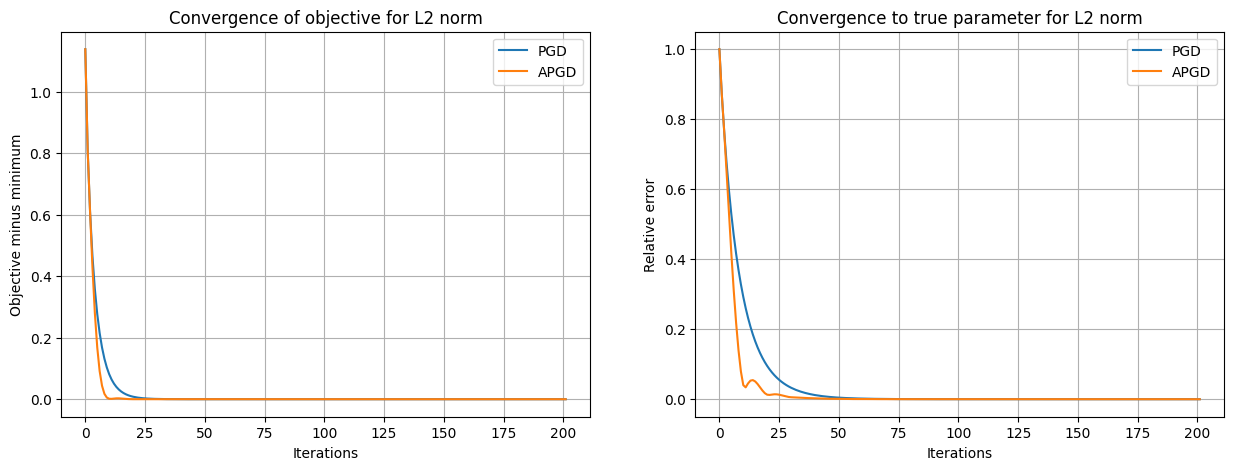

In [ ]:
A, b = simu_linreg(coefs)
L_linreg=smoothness_const_linreg(A)
step_linreg = 1/L_linreg
x_precise_2, obj_precise_2, _ =APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                                 step_linreg, lmbd=lmbd, n_iter=1000 ,verbose=False)

f_star_2 = obj_precise_2[-1]

# Compare PGD and APGD
x_pgd_2, obj_pgd_2, err_pgd_2 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                              step_linreg, lmbd=lmbd, n_iter=200, x_true=x_precise_2, verbose=False)
x_apgd_2, obj_apgd_2, err_apgd_2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                                  step_linreg,lmbd=lmbd, n_iter=200,x_true=x_precise_2, verbose=False)

# Plot convergence
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(obj_pgd_2 - f_star_2, label='PGD')
plt.plot(obj_apgd_2 - f_star_2, label='APGD')
plt.xlabel('Iterations')
plt.ylabel('Objective minus minimum')
plt.legend()
plt.grid()
plt.title('Convergence of objective for L2 norm')

plt.subplot(122)
plt.plot(err_pgd_2, label='PGD')
plt.plot(err_apgd_2, label='APGD')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.legend()
plt.grid()
plt.title('Convergence to true parameter for L2 norm')

<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
<b>PGD</b> shows a consistent, smooth decrease in the objective function. The convergence is steady, but slow compared to <b>APGD</b>.<br><br>
<b>APGD</b> decreases the objective faster at first, with oscillations as it accelerates the convergence. Despite the oscillations, it consistently outperforms PGD in terms of reaching the minimum more quickly.<br><br>
For the second plot, <b>PGD</b> initially converges more slowly compared to <b>APGD</b> and reaches the solution with larger relative errors at early iterations. <b>APGD</b> converges to the true parameter much faster and stabilizes earlier, exhibiting a smooth and rapid decrease in relative error.<br><br>
We can conclude that <b>APGD</b> is significantly faster than <b>PGD</b> for both the objective function minimization and parameter estimation. It provides more efficient convergence, making it a better choice for optimization tasks, though the oscillations should be noted as a characteristic of accelerated methods.
</div>


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

Text(0.5, 1.0, 'APGD solution')

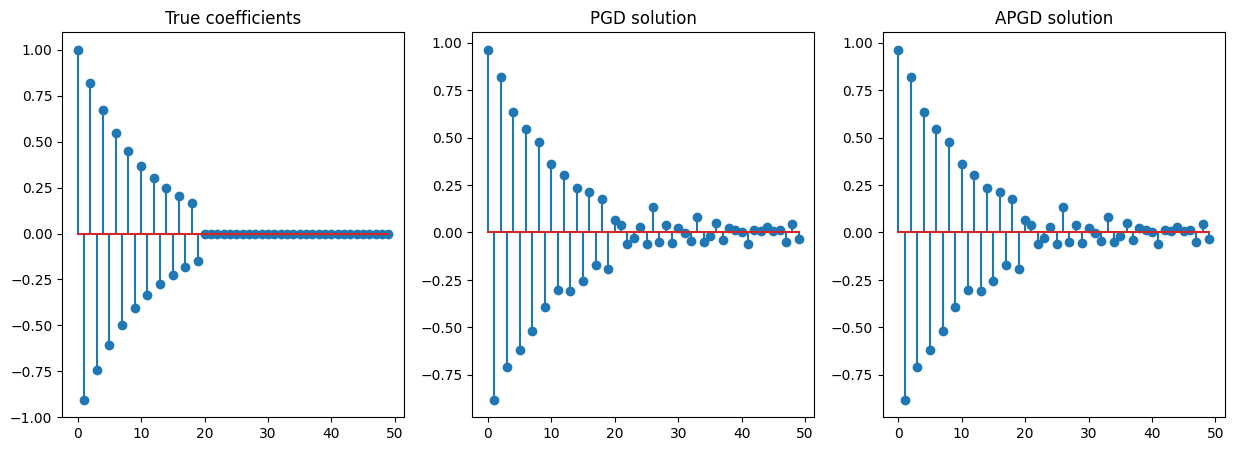

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.stem(coefs)
plt.title('True coefficients')
plt.subplot(132)
plt.stem(x_pgd_2)
plt.title('PGD solution')
plt.subplot(133)
plt.stem(x_apgd_2)
plt.title('APGD solution')


<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
Here, we clearly see that both algorithms converge to the same solution with <b>L2 regularizer</b>. We have very similar coefficients. The global solution tends to the optimal solution we are looking for.
</div>


Text(0.5, 1.0, 'APGD solution')

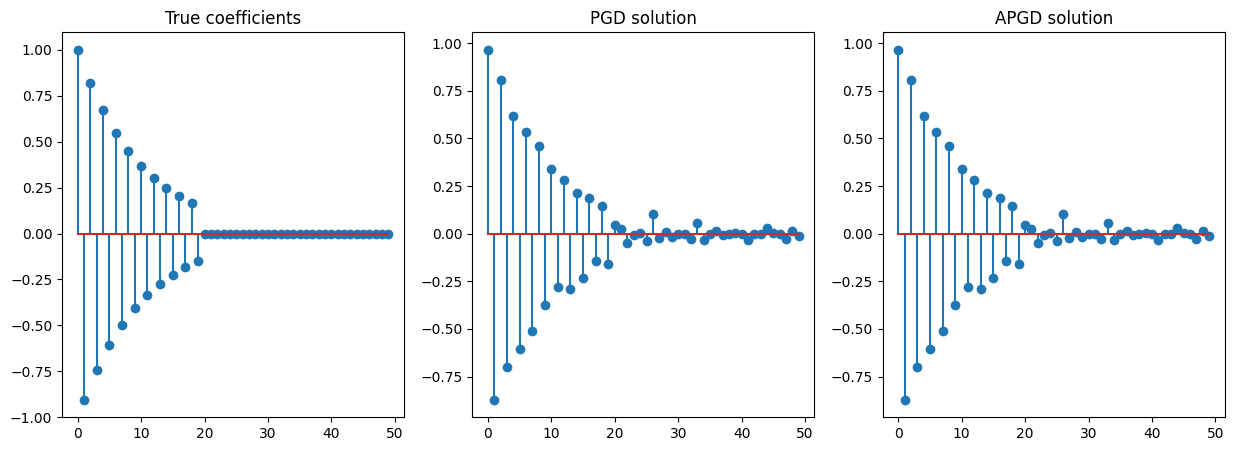

In [ ]:
lmbd = 1e-2
x_precise_1, obj_precise_1, _ = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                                 step_linreg,lmbd=lmbd, n_iter=1000, verbose=False)
f_star_1 = obj_precise_1[-1]
x_pgd_1, obj_pgd_1, err_pgd_1 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                              step_linreg, lmbd=lmbd, n_iter=n_iter,x_true=x_precise_1, verbose=False)
x_apgd_1, obj_apgd_1, err_apgd_1 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                                  step_linreg,lmbd=lmbd, n_iter=n_iter,x_true=x_precise_1, verbose=False)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.stem(coefs)
plt.title('True coefficients')
plt.subplot(132)
plt.stem(x_pgd_1)
plt.title('PGD solution')
plt.subplot(133)
plt.stem(x_apgd_1)
plt.title('APGD solution')


<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
Here, we clearly see that both algorithms converge to the same solution with <b>L1 regularizer</b>. We have very similar coefficients. The global solution tends to the optimal solution we are looking for.
</div>


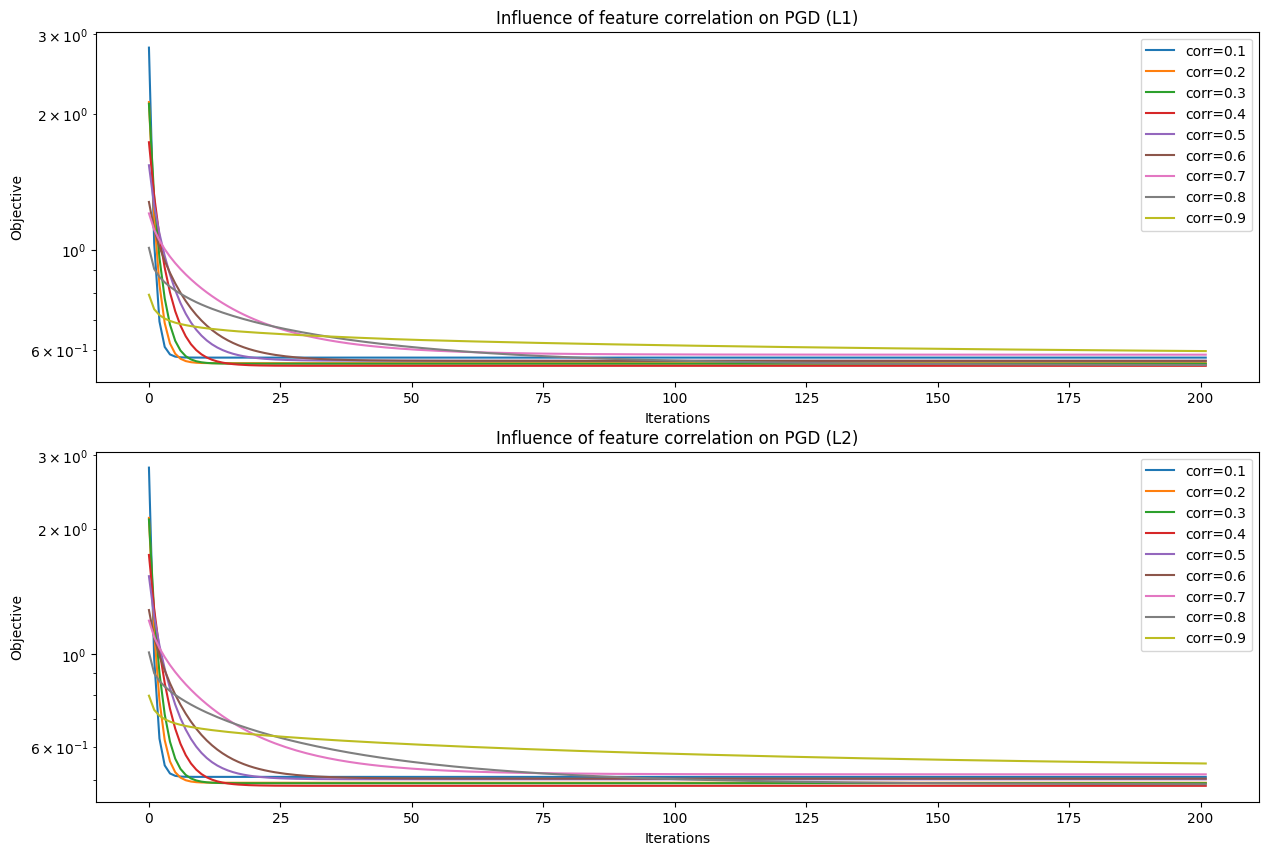

In [ ]:

# Study correlation influence for L1 norm
correlations = [0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8, 0.9]
plt.figure(figsize=(15, 10))
x0 = np.zeros(n_features)
lmbd = 1e-2
for corr in correlations:
    A, b = simu_linreg(coefs, corr=corr)
    L_corr = smoothness_const_linreg(A)
    step_corr = 1.0 / L_corr
    _, obj_corr, _ = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                          step_corr, lmbd=0.01, n_iter=n_iter, verbose=False)
    plt.subplot(2, 1, 1)
    plt.semilogy(obj_corr, label=f'corr={corr}')

    plt.xlabel('Iterations')
    plt.ylabel('Objective')
    plt.legend()
    plt.title('Influence of feature correlation on PGD (L1)')

    _, obj_corr, _ = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                          step_corr, lmbd=0.01, n_iter=n_iter, verbose=False)
    plt.subplot(2, 1, 2)
    plt.semilogy(obj_corr, label=f'corr={corr}')
    plt.xlabel('Iterations')
    plt.ylabel('Objective')

    plt.legend()
    plt.title('Influence of feature correlation on PGD (L2)')




<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
As the correlation between features increases, the objective function converges more slowly when <b>L1</b> and <b>L2 regularizer</b> is applied on <b>PGD</b>. Highly correlated features make optimization more challenging and more complex.
</div>


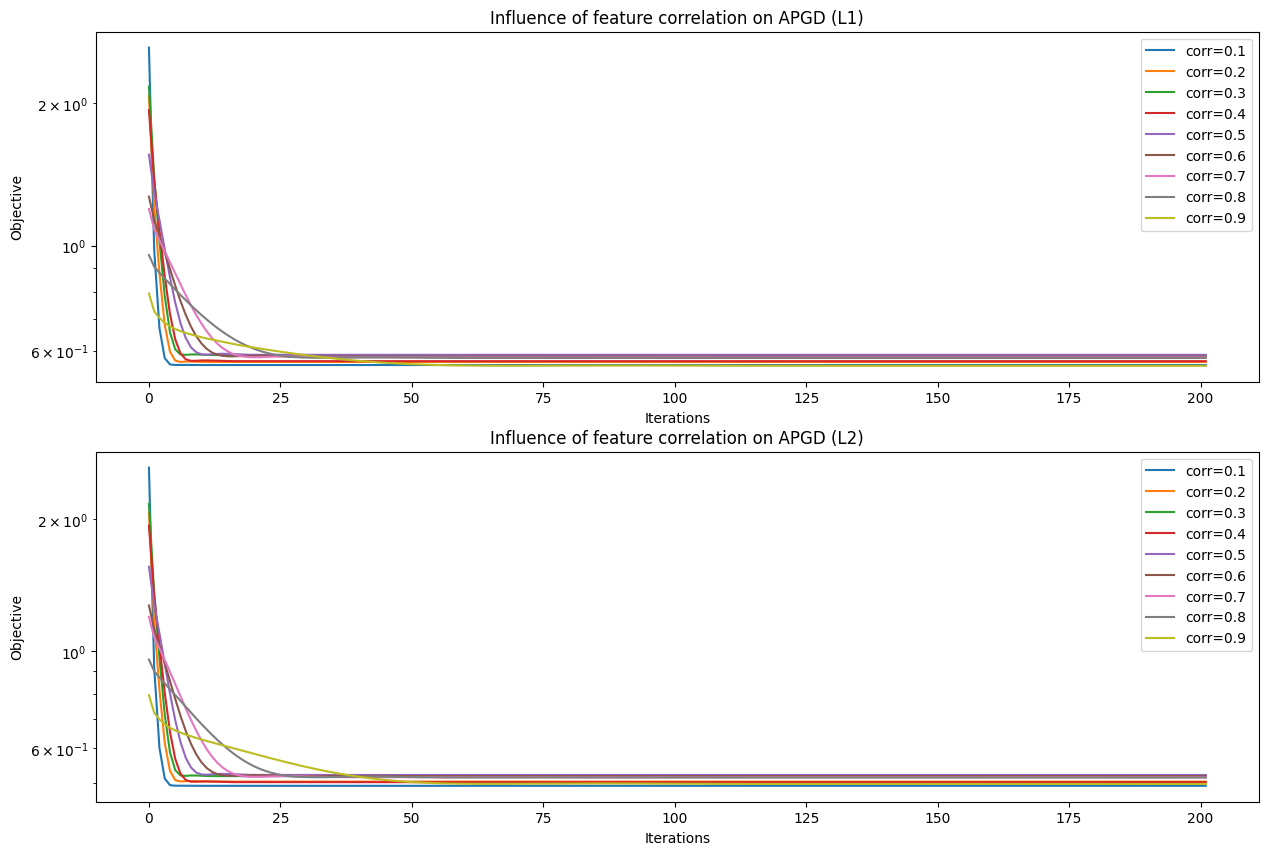

In [ ]:

# Study correlation influence for L1 norm
correlations = [0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8, 0.9]
plt.figure(figsize=(15, 10))
for corr in correlations:
    A, b = simu_linreg(coefs, corr=corr)
    L_corr = smoothness_const_linreg(A)
    step_corr = 1.0 / L_corr


    plt.subplot(2, 1, 1)
    plt.semilogy(APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                          step_corr  ,lmbd=0.01, n_iter=n_iter, verbose=False)[1], label=f'corr={corr}')
    plt.xlabel('Iterations')
    plt.ylabel('Objective')
    plt.legend()
    plt.title('Influence of feature correlation on APGD (L1)')


    plt.subplot(2, 1, 2)
    plt.semilogy(APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                          step_corr,  lmbd=0.01, n_iter=n_iter, verbose=False)[1], label=f'corr={corr}')
    plt.xlabel('Iterations')
    plt.ylabel('Objective')
    plt.legend()
    plt.title('Influence of feature correlation on APGD (L2)')

<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
Same as PGD, as the correlation between features increases, the objective function converges more slowly when <b>L1</b> and <b>L2 regularizer</b> is applied on <b>APGD</b>. Highly correlated features make optimization more challenging and more complex.
</div>


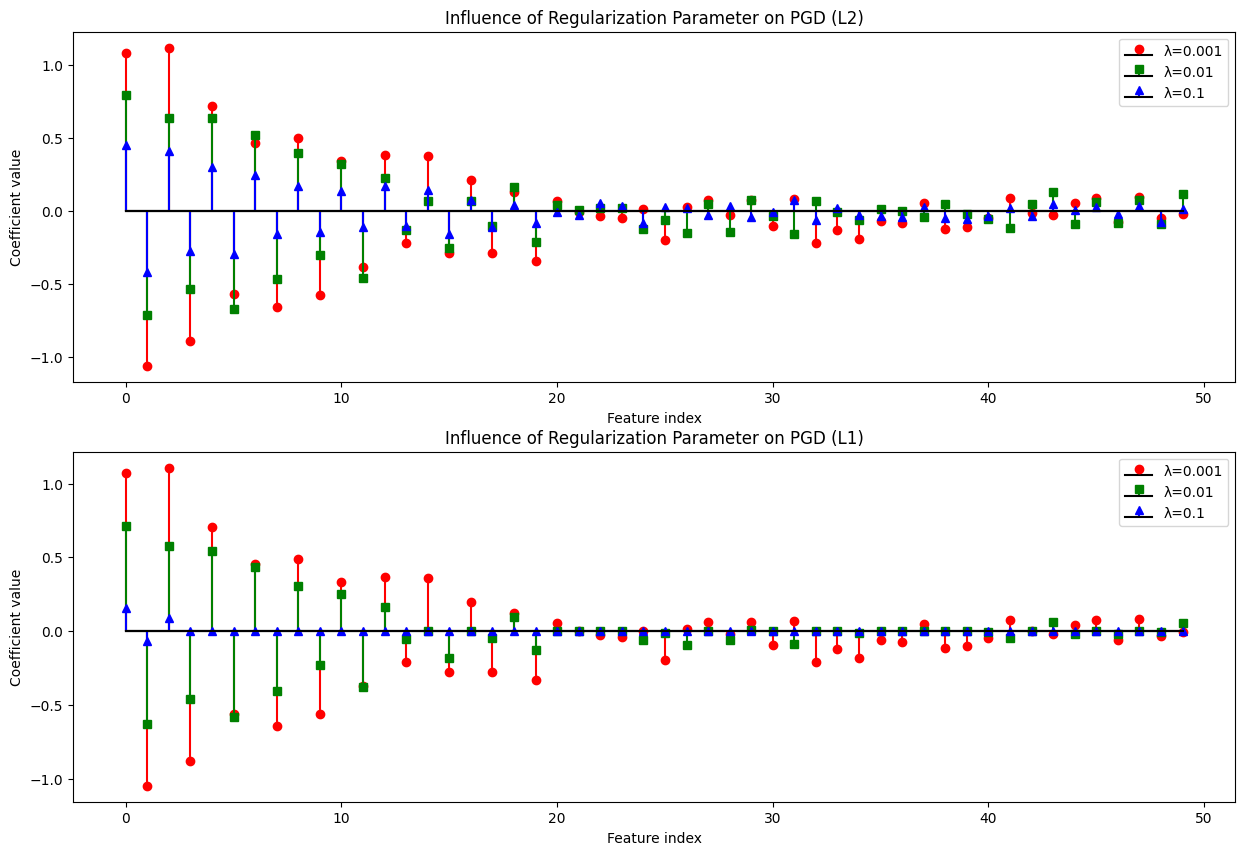

In [ ]:
lambdas = [1e-3, 1e-2, 1e-1]
colors = ['r', 'g', 'b']  # Define a list of colors
markers = ['o', 's', '^']  # Define a list of marker styles

plt.figure(figsize=(15, 10))
for lmbd, color, marker in zip(lambdas, colors, markers):
    A, b = simu_logreg(coefs, corr=0.1) #corr set to 0.1 as we have shown before that lower correlation fasten the convergence
    L = smoothness_const_loreg(A)
    step = 1 / L
    x_lmbd, obj_lmbd, _ = PGD(
        x0, loss_logreg, grad_logreg, L2_norm, prox_L2,
        step, lmbd=lmbd, n_iter=n_iter, verbose=False
    )
    markerfmt = color + marker
    linefmt = color + '-'
    plt.subplot(2, 1, 1)
    plt.stem(
        x_lmbd,
        linefmt=linefmt,
        markerfmt=markerfmt,
        basefmt="k-",
        label=f'λ={lmbd}'
    )

    plt.xlabel('Feature index')
    plt.ylabel('Coefficient value')
    plt.legend()
    plt.title('Influence of Regularization Parameter on PGD (L2)')
    x_lmbd, obj_lmbd, _ = PGD(
        x0, loss_logreg, grad_logreg, L1_norm, prox_L1,
        step, lmbd=lmbd, n_iter=n_iter, verbose=False
    )
    plt.subplot(2, 1, 2)
    plt.stem(
        x_lmbd,
        linefmt=linefmt,
        markerfmt=markerfmt,
        basefmt="k-",
        label=f'λ={lmbd}'
    )
    plt.xlabel('Feature index')
    plt.ylabel('Coefficient value')

    plt.legend()
    plt.title('Influence of Regularization Parameter on PGD (L1)')



<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
For <b>PGD</b>, increasing the regularization parameter shrinks the coefficients towards zero, promoting simpler models and reducing the risk of overfitting. It is even more evident with <b>L1 regularizer</b> as it shrinks the coefficients to 0.<br><br>
However, larger λ values introduce more bias, which could result in underfitting, whereas smaller λ values offer more flexibility but can lead to overfitting.<br><br>
<b>The choice of λ should balance between overfitting and underfitting.</b>
</div>


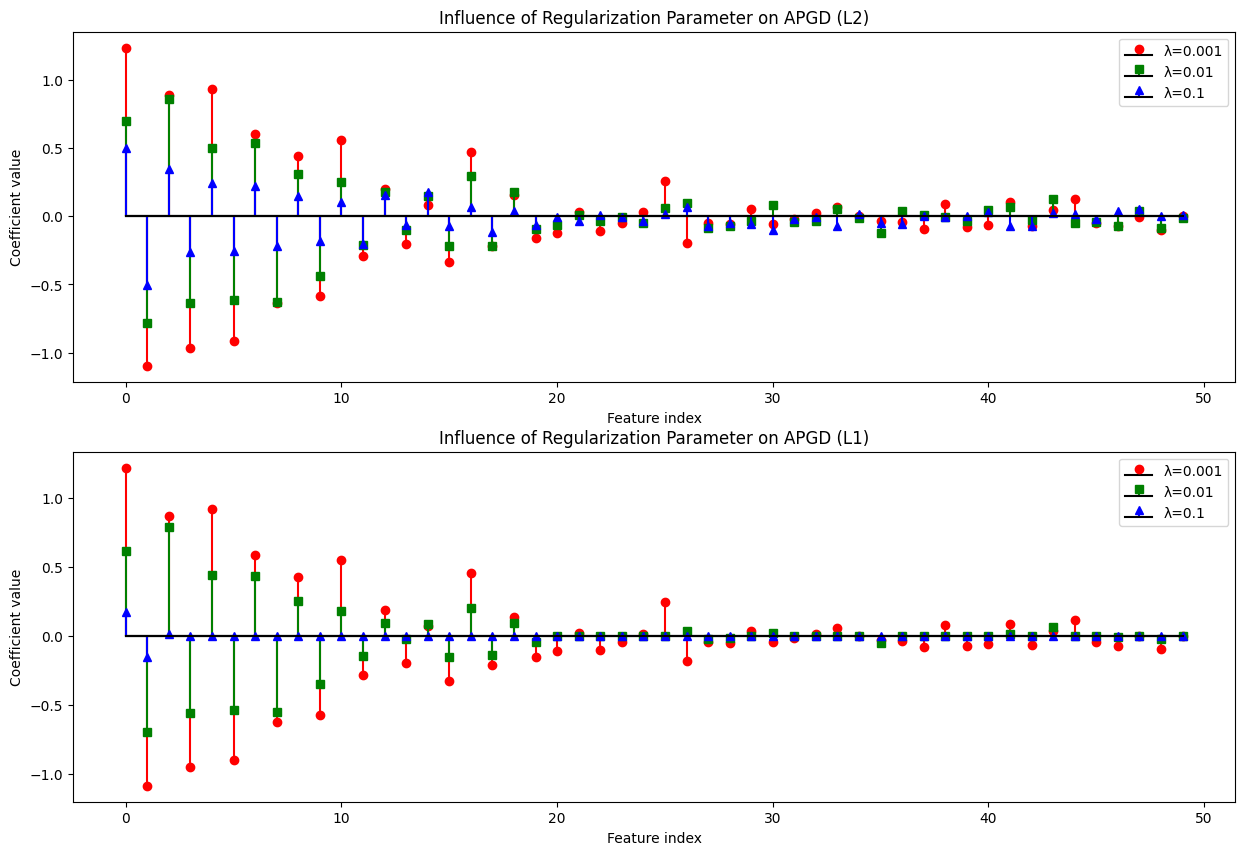

In [ ]:

plt.figure(figsize=(15, 10))
for lmbd, color, marker in zip(lambdas, colors, markers):
    A, b = simu_logreg(coefs, corr=0.1) #corr set to 0.1 as we have shown before that lower correlation fasten the convergence
    L = smoothness_const_loreg(A)
    step = 1 / L
    x_lmbd, obj_lmbd, _ = APGD(
        x0, loss_logreg, grad_logreg, L2_norm, prox_L2,
        step, lmbd=lmbd, n_iter=n_iter, verbose=False
    )
    markerfmt = color + marker
    linefmt = color + '-'
    plt.subplot(2, 1, 1)
    plt.stem(
        x_lmbd,
        linefmt=linefmt,
        markerfmt=markerfmt,
        basefmt="k-",
        label=f'λ={lmbd}'
    )

    plt.xlabel('Feature index')
    plt.ylabel('Coefficient value')
    plt.legend()
    plt.title('Influence of Regularization Parameter on APGD (L2)')
    x_lmbd, obj_lmbd, _ = APGD(
        x0, loss_logreg, grad_logreg, L1_norm, prox_L1,
        step, lmbd=lmbd, n_iter=n_iter, verbose=False
    )
    plt.subplot(2, 1, 2)
    plt.stem(
        x_lmbd,
        linefmt=linefmt,
        markerfmt=markerfmt,
        basefmt="k-",
        label=f'λ={lmbd}'
    )
    plt.xlabel('Feature index')
    plt.ylabel('Coefficient value')

    plt.legend()
    plt.title('Influence of Regularization Parameter on APGD (L1)')



<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
Same as <b>PGD</b>, increasing the regularization parameter shrinks the coefficients towards zero for <b>APGD</b>, promoting simpler models and reducing the risk of overfitting. It is even more evident with <b>L1 regularizer</b> as it shrinks the coefficients to 0.<br><br>
However, larger λ values introduce more bias, which could result in underfitting, whereas smaller λ values offer more flexibility but can lead to overfitting.<br><br>
<b>The choice of λ should balance between overfitting and underfitting.</b>
</div>
